<a href="https://colab.research.google.com/github/GabyDs/EjerciciosInteligenciaComputacional/blob/main/Aprendizaje_RNA_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje en Redes Neuronales Artificiales

## Aprendizaje Supervisado - Red Neuronal Básica
### Introducción:
Se implementa una clase que construye una red neuronal de acuerdo a los parámetros seleccionados. 
Dentro de los parámetros, se define la cantidad de neuronas por capa, siendo la red más simple de implementar, una de 3 capas: *entrada*, *capa oculta* y *salida*.

Cada capa se vincula como *full connected* y la función de activación por neurona es constante. Es decir, si se especifica una "*sigmoide*", la misma se aplica a todas las neuronas. Las funciones de activación disponibles son: `tanh`, `sigmoid` y `softplus`.

Además, en la topología usada se agrega 1 neurona extra en la capa de entrada y 1 neurona extra en las capas ocultas a modo de "*Bias*". Esta es una forma de mejorar la precisión de la red neuronal, dandole mayor “libertad algebraica”.

La clase, permite realizar el entrenamiento sobre la red construida. Para este proceso se necesitan los datos de entrada y salida, además de la tasa de aprendizaje y el número de épocas. Se tiene un método para realizar predicciones sobre la red entrenada. Además, se pueden consultar los pesos y deltas resultantes.

Los datos de entrada y salida únicamente pueden encontrarse entre -1 y 1.



### Clase NeuralNetwork

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, layers, activation='tanh'):
        """
        Inicialización de la clase.

        USO:
        layers          -> Capas de la red. Lista de Python. Ej: [2,4,1]
                        ... Red con 3 capas. 2 Neuronas a la entrada, 4 en la
                        ... capa oculta y 1 en la salida.
        activation      -> Función de activación a utilizar. Se admite:
                        ... 'sigmoid', 'tanh' y 'softplus'.
        """
        if activation == 'sigmoid':
            self.activation = self.__sigmoid
            self.activation_prime = self.__sigmoid_derivada
        elif activation == 'tanh':
            self.activation = self.__tanh
            self.activation_prime = self.__tanh_derivada
        elif activation == 'softplus':
            self.activation = self.__softplus
            self.activation_prime = self.__softplus_derivada
        else:
            raise ValueError("Activación '{}' no definida.".format(activation))
        
        if not (isinstance(layers, list) or isinstance(layers, tuple)):
            raise TypeError("La información de las capas debe ser una lista o tupla.")
        
        if len(layers)<3:
            raise ValueError("Se necesitan al menos 3 capas (Entrada, Oculta, Salida). Ej: [2,3,2]")

        # Inicialización de los pesos
        self.weights = []
        self.deltas = []
        self.layers = layers

        # Asignación de valores aleatorios a las capas. Rango (-1,1).
        # Capa de entrada y ocultas
        for i in range(1, len(layers) - 1):
            r = 2*np.random.random((layers[i-1] + 1, layers[i] + 1)) -1
            self.weights.append(r)
        # Capa de salida
        r = 2*np.random.random((layers[i] + 1, layers[i+1])) - 1
        self.weights.append(r)

    # Funciones de activación disponibles
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_derivada(self, x):
        return 1.0 - np.tanh(x)**2
    
    def __softplus(self, x):
        return np.log(np.power(np.e, x) +1)

    def __softplus_derivada(self, x):
        return np.power(np.e, x)/(np.power(np.e, x)+1)
    
    def __sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))

    def __sigmoid_derivada(self, x):
        return self.__sigmoid(x)*(1.0-self.__sigmoid(x))

    def fit(self, X, y, learning_rate=0.2, epochs=10000):
        """
        Método para el entrenamiento de la red. Puede utilizarse de forma secuencial
        para continuar el entrenamiento. Los pesos se inicializan aleatoriamente
        únicamente en la instanciación de la clase.
        
        USO:
        X               -> Entrada. Array de Numpy, ver ejemplo.
        y               -> Salida. Array de Numpy, ver ejemplo.
        learning_rate   -> Tasa de aprendizaje
        epochs          -> Épocas de entrenamiento
        """
        # Agrego columna de unos a las entradas X
        # Con esto agregamos la unidad de Bias a la capa de entrada
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)
        
        for k in range(epochs):
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):
                    dot_value = np.dot(a[l], self.weights[l])
                    activation = self.activation(dot_value)
                    a.append(activation)
            # Calculo la diferencia en la capa de salida y el valor obtenido
            error = y[i] - a[-1]
            deltas = [error * self.activation_prime(a[-1])]
            
            # Empezamos en el segundo layer hasta el ultimo
            # (Una capa anterior a la de salida)
            for l in range(len(a) - 2, 0, -1): 
                deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_prime(a[l]))
            self.deltas.append(deltas)

            # invertir
            # [level3(output)->level2(hidden)]  => [level2(hidden)->level3(output)]
            deltas.reverse()

            # backpropagation
            # 1. Multiplcar los delta de salida con las activaciones de entrada 
            #    para obtener el gradiente del peso.
            # 2. actualizo el peso restandole un porcentaje del gradiente
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)

            # Se imprimen carteles cada 10000 iteraciones, para corroborar el proceso
            #if k % 10000 == 0: print('epochs:', k)

    def predict(self, x):
        """
        Método para realizar una predicción a partir de los datos de entrada.
        Con esto se puede calcular el accuracy por ejemplo.
        """
        ones = np.atleast_2d(np.ones(x.shape[0]))
        a = np.concatenate((np.ones(1).T, np.array(x)), axis=0)
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a

    def print_weights(self):
        """
        Método para imprimir los pesos resultantes en el último entrenamiento.
        """
        print("LISTADO PESOS DE CONEXIONES")
        for i in range(len(self.weights)):
            print(self.weights[i])

    def get_deltas(self):
        """
        Método para obtener los deltas del proceso de entrenamiento.
        Con esto se puede graficar el costo por época por ejemplo.
        """
        return self.deltas
    
    def plot_cost(self):
        """
        Método para graficar el costo a partir de los deltas.
        """
        deltas = self.get_deltas()
        valores=[]
        for arreglo in deltas:
            temp = 0
            for val in range(len(arreglo[len(arreglo)-1])):
                temp += arreglo[len(arreglo)-1][val]
            valores.append(temp)
        plt.plot(range(len(valores)), valores, color='b')
        plt.ylim([0, max(valores)])
        plt.title("RNA: {}".format(self.layers))
        plt.ylabel('Costo')
        plt.xlabel('Épocas')
        plt.tight_layout()
        plt.show()

## Ejercicio 1 - Compuerta XOR

In [3]:
### Compuerta XOR ###

# Instanciación de la RNA
nn = NeuralNetwork([2, 2, 1], 'tanh')
"""
Notar que la capa de entrada debe tener tantas neuronas como datos de entrada.
Lo mismo para la capa de salida.
Las capas ocultas pueden ser varias, con distintas neuronas. Las conexiones se
realizan como full conected.
"""

# Datos de Entrada
#X = np.array([[0, 0],
#            [0, 1],
#            [1, 0],
#            [1, 1]])


# Dispersion de entrada
X = np.array([[17, 2],
            [14, 1],
            [12, 5],
            [1, 9]])

# Datos de Salida
y = np.array([0, 1, 1, 0])

# Etapa de Entrenamiento
nn.fit(X, y, learning_rate=0.05, epochs=10000)

# Predicciones de la red a partir de los datos de entrada
for e in X:
    print("\tEntrada: ", e, "Salida: ", nn.predict(e))

epochs: 0
	Entrada:  [17  2] Salida:  [0.41596066]
	Entrada:  [14  1] Salida:  [0.41629367]
	Entrada:  [12  5] Salida:  [0.9208485]
	Entrada:  [1 9] Salida:  [0.08716356]


In [20]:
# Para visualizar los pesos de la RNA
nn.print_weights()

LISTADO PESOS DE CONEXIONES
[[ 0.43421732 -0.8182561  -0.36607983  1.6284897   0.8335909  -1.1288396
  -1.35056809]
 [ 1.13550484  2.89774838 -2.31122619 -1.08049407  0.30872237 -0.72960779
   0.89183564]
 [ 1.34776283 -2.11832436  2.68663442 -0.84566087  0.0814908   0.99968388
  -0.32733009]]
[[-2.25645943]
 [ 3.52846264]
 [ 3.35914714]
 [-2.29597216]
 [-1.10863146]
 [ 0.89869645]
 [ 0.56240604]]


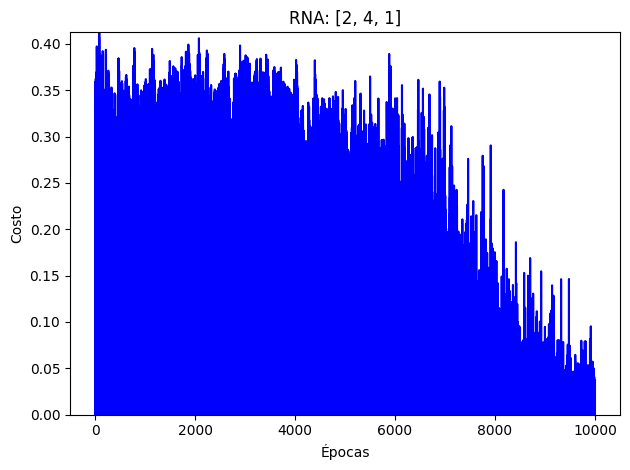

In [40]:
# Para la gráfica de costo en función de las épocas
nn.plot_cost()

## Ejercicio 2 - Función de Transferencia Modelizada

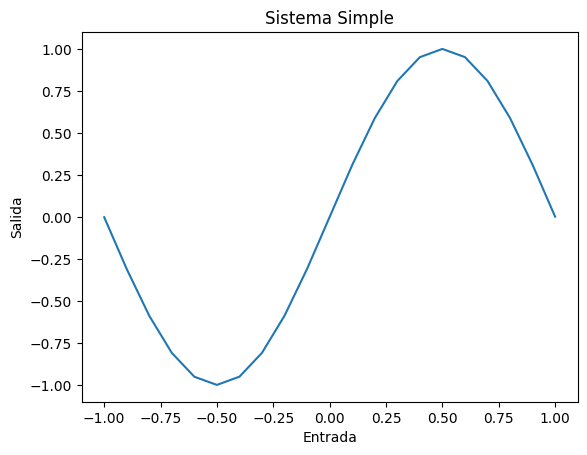

In [ ]:
# Generación de los datos para entrenamiento y test.
x = []
y = []

for i in range(-10,11):
    val = i/10
    x.append(val)
    y.append(np.sin(val*3.14))

plt.plot(x, y)
plt.title('Sistema Simple')
plt.ylabel('Salida')
plt.xlabel('Entrada')
plt.show()

In [ ]:
# Adecuación de tipo de datos 
X = np.array(x).reshape(len(x),1)
Y = np.array(y).reshape(len(y),1)

# Inicialización
nn2 = NeuralNetwork([1,3,1], 'tanh')
"""
Notar que en la topología de ejemplo, la capa de entrada y salida
tienen 1 neurona. Misma explicación que el ejercicio 1.
Entra 1 valor, sale 1 valor. Debe haber coherencia en estas dimensiones.
En las capas ocultas... va el arte :)
"""

# Entrenamiento
nn2.fit(X, Y, learning_rate=0.1, epochs=10000)

epochs: 0


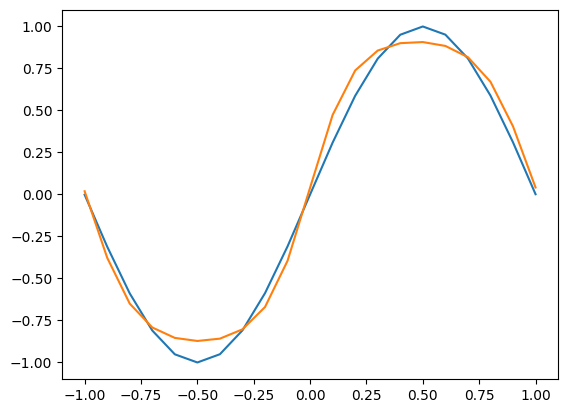

In [ ]:
# Ejemplo para validar predicciones de la red:
# Comparación muy visual para ver (literalmente) si la
# RNA va por buen camino en el aprendizaje

y_predict = []
for e in X:
    y_predict.append(nn2.predict(e))
plt.plot(x, y, x, y_predict)
plt.show()
# Agregar ejes, título, etc.

## Ejercicio 3 - Clasificación Iris

In [2]:
# Importación del dataset
from sklearn import datasets

# Preprocesamiento
dataset = datasets.load_iris()
features = np.array(dataset.data[:,:4])
label = np.array(dataset.target)
label = np.resize(label,(label.shape[0],1))

# Se transforman los datos al rango de entrada aceptado
# por nuestra RNA

# Etiquetas de clases
esc_label = label.max()

# Salida
label_esc = label / esc_label

print("Codificación numérica de las clases categóricas:")
for i in range(3):
    print("Clase: {} - etiqueta: {}".format(dataset.target_names[i], i/esc_label))

# Descriptores
esc_features = features.max()

# Entrada
features_esc = features / esc_features

print("Referencias de las columnas de los descriptores:")
print(dataset.feature_names)
# Ya no están en cm, se tranformó al rango (0;1)

Codificación numérica de las clases categóricas:
Clase: setosa - etiqueta: 0.0
Clase: versicolor - etiqueta: 0.5
Clase: virginica - etiqueta: 1.0
Referencias de las columnas de los descriptores:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [3]:
# Dividir train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_esc, label_esc, test_size=0.3, random_state=42, shuffle=True)

In [4]:
def setup(capas, learning_rate, epochs):
  # Prueba de Iris
  nn3 = NeuralNetwork(capas, 'tanh')

  nn3.fit(X_train, y_train, learning_rate, epochs)

  return nn3

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

def calcular_r2_mse(y_real, y_pred):
  # Calcula el MSE
  mse = mean_squared_error(y_real, y_pred)
  mse = round(mse, 2)

  # Calcula el R2
  r2 = r2_score(y_real, y_pred)
  r2 = round(r2, 2)

  return r2, mse

In [6]:
# Prueba sobre predicciones Iris:
# Se utiliza los datos de test para comparar
count = 0

# media de las predicciones de cada clase
media_cero = 0
media_cero_cinco = 0
media_uno = 0

count_cero = 0
count_cero_cinco = 0
count_uno = 0

valores_predichos = []

In [7]:
def predecir(capas, learning_rate, epochs):

  nn3 = setup(capas, learning_rate, epochs)

  # Prueba sobre predicciones Iris:
  # Se utiliza los datos de test para comparar
  count = 0

  # media de las predicciones de cada clase
  media_cero = 0
  media_cero_cinco = 0
  media_uno = 0

  count_cero = 0
  count_cero_cinco = 0
  count_uno = 0

  valores_predichos = []

  for e in X_test:
      #print("Real: {} vs Predicho: {}".format(y_test[count], nn3.predict(e)))

      valor_predicho = nn3.predict(e)

      valores_predichos.append(valor_predicho)

      if y_test[count] == 0.:
        media_cero += valor_predicho
        count_cero += 1
      elif y_test[count] == 0.5:
        media_cero_cinco += valor_predicho
        count_cero_cinco += 1
      else:
        media_uno += valor_predicho
        count_uno += 1

      count +=1

  media_cero = media_cero / count_cero
  media_cero_cinco = media_cero_cinco / count_cero_cinco
  media_uno = media_uno / count_uno

  r2, _ = calcular_r2_mse(y_test, valores_predichos)

  return r2, valores_predichos, media_cero, media_cero_cinco, media_uno


In [8]:
def obtener_configuracion(learning_rate, epochs):
  # Se genera un vector dinamico que representa las veces de las capas y neuronas
  # aumentando de 2 en 2 la cantidad de neuronas y de a 1 la cantidad de capas
  # se limitara el aumento en base a una metrica de la prediccion

  vector = [4, 1, 1]
  original = vector.copy() # se guarda una copia del vector original

  for i in range(10): # se ejecuta el ciclo 10 veces

      r2, valores_predichos, media_cero, media_cero_cinco, media_uno = predecir(vector, learning_rate, epochs)

      if r2 >= 0.95:
        return r2, vector, valores_predichos, media_cero, media_cero_cinco, media_uno


      if i == 5: # cuando se llega a la iteración 5
          vector = original.copy() # se restaura el vector original
          vector.insert(-1, 1) # se agrega una posición más
      else:
          for j in range(1, len(vector)-1): # se recorren las posiciones entre la primera y la última
              vector[j] *= 2 # se multiplican por 2

  return 0, [0], [0], 0, 0, 0

In [16]:
learning_rate = 0.1
epochs = 10000

In [17]:
r2, config, valores_predichos, media_cero, media_cero_cinco, media_uno = obtener_configuracion(learning_rate, epochs)

if config[0] != 0:
  print("El valor de r2 es: ", r2)
  print("La configuracion es: ", config)
else:
  print("No se obtuvo ninguna configuracion")

El valor de r2 es:  0.96
La configuracion es:  [4, 2, 2, 1]


In [11]:
bins = 10
delta_rate = (5 - learning_rate) / bins

lista_mse = []
lista_rate = []

for i in range(bins):
  _, valores_predichos, _, _, _ = predecir(config, learning_rate, epochs)
  _, mse = calcular_r2_mse(valores_predichos, y_test)

  lista_mse.append(mse)
  lista_rate.append(learning_rate)

  learning_rate = round(learning_rate+delta_rate, 2)

In [12]:
epochs = 1

lista_mse = []
lista_epochs = []

for i in range(50):
  _, valores_predichos, _, _, _ = predecir(config, learning_rate, epochs)
  _, mse = calcular_r2_mse(valores_predichos, y_test)

  lista_mse.append(mse)
  lista_epochs.append(epochs)

  epochs += 5

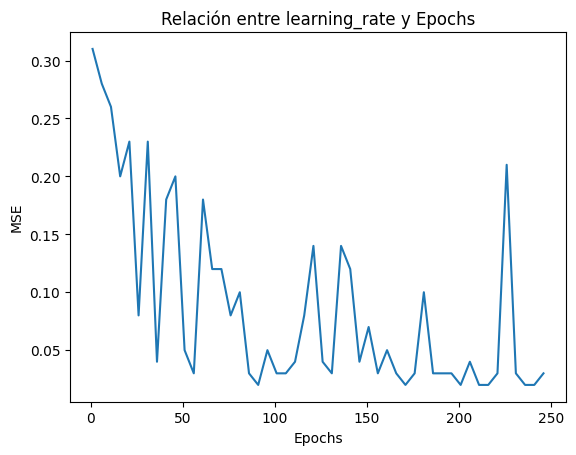

In [120]:
import matplotlib.pyplot as plt

plt.plot(lista_epochs, lista_mse)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Relación entre learning_rate y Epochs')
plt.show()

In [18]:
print("Prediccion media de la clase 0   -> {}".format(media_cero))
print("Prediccion media de la clase 0.5 -> {}".format(media_cero_cinco))
print("Prediccion media de la clase 1   -> {}".format(media_uno))

Prediccion media de la clase 0   -> [0.00937802]
Prediccion media de la clase 0.5 -> [0.58959778]
Prediccion media de la clase 1   -> [0.94940376]


In [19]:
# Calculamos la diferencia porcentual del valor real con el predicho
porcentaje_cero = abs((0 - abs(media_cero[0]))) * 100
porcentaje_cero_cinco = abs((0.5 - abs(media_cero_cinco[0]))) * 100
porcentaje_uno = abs((1 - abs(media_uno[0]))) * 100

In [20]:
print("Dispersion del {}% en la clase 0".format(round(porcentaje_cero, 2)))
print("Dispersion del {}% en la clase 0.5".format(round(porcentaje_cero_cinco, 2)))
print("Dispersion del {}% en la clase 1".format(round(porcentaje_uno, 2)))

Dispersion del 0.94% en la clase 0
Dispersion del 8.96% en la clase 0.5
Dispersion del 5.06% en la clase 1


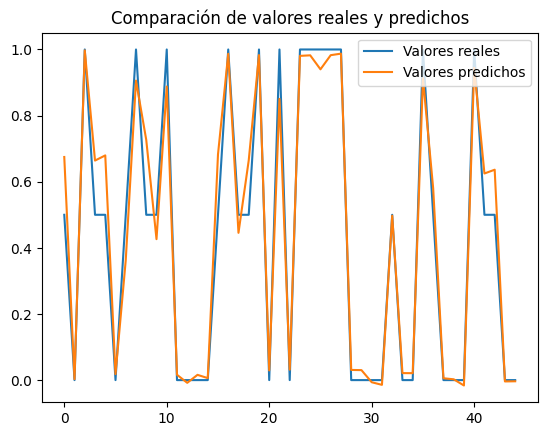

In [21]:
import matplotlib.pyplot as plt

# Grafica de valores predichos frente a los reales
valores_reales = y_test

# Grafica los valores reales
plt.plot(valores_reales, label='Valores reales')

# Grafica los valores predichos
plt.plot(valores_predichos, label='Valores predichos')

# Agrega una leyenda
plt.legend()

# Agrega un título
plt.title('Comparación de valores reales y predichos')

# Muestra la gráfica
plt.show()


In [22]:
r2, mse = calcular_r2_mse(valores_reales, valores_predichos)

# Imprime los resultados
print("MSE:", mse)
print("R2:", r2)

MSE: 0.01
R2: 0.96


In [38]:
# Codificacion

for vp in valores_predichos:
  if vp <= 0.3:
    #print("Valor predicho: {}, \t pertenece a la clase 0".format(round(vp[0], 4)))
    pass
  elif (0.3 < vp <= 0.7):
    #print("Valor predicho: {}, \t pertenece a la clase 0.5".format(round(vp[0], 4)))
    pass
  else:
    print("Valor predicho: {}, \t pertenece a la clase 1".format(round(vp[0], 3)))
    pass

Valor predicho: 0.997, 	 pertenece a la clase 1
Valor predicho: 0.906, 	 pertenece a la clase 1
Valor predicho: 0.726, 	 pertenece a la clase 1
Valor predicho: 0.888, 	 pertenece a la clase 1
Valor predicho: 0.987, 	 pertenece a la clase 1
Valor predicho: 0.983, 	 pertenece a la clase 1
Valor predicho: 0.851, 	 pertenece a la clase 1
Valor predicho: 0.981, 	 pertenece a la clase 1
Valor predicho: 0.982, 	 pertenece a la clase 1
Valor predicho: 0.94, 	 pertenece a la clase 1
Valor predicho: 0.983, 	 pertenece a la clase 1
Valor predicho: 0.987, 	 pertenece a la clase 1
Valor predicho: 0.913, 	 pertenece a la clase 1
Valor predicho: 0.944, 	 pertenece a la clase 1


# Aprendizaje No Supervisado - Red Neuronal para Clustering
### Introducción:
Se implementa una función que realiza un *clustering* sobre el conjunto de datos recibido. Se debe especificar la cantidad de clusters, y de forma opcional, la tasa de aprendizaje y el número de épocas.

### Función: neuro_clustering

In [ ]:
import pandas as pd
def neuro_clustering(data, k, learning_rate=0.1, epochs=20):
    """
    USO:
        data            -> Datos. Array de Numpu. Ver ejemplo.
        k               -> Número de Clusters. Entero.
        learning_rate   -> Tasa de aprendizaje
        epochs          -> Épocas de entrenamiento
    """
    x = data
    data_size, feature_size = x.shape[0], x.shape[1]  # data_size=n and feature_size=m
    
    # Inicializaciones de los pesos
    means = x.mean(0)
    std = x.std(0)
    weights = np.zeros((k,feature_size))
    
    for features in range(feature_size):
        weights[:,features:features+1] = np.random.normal(means[features], std[features], (k, 1))
    
    delta_change = []
    for i in range(epochs):
        np.random.shuffle(x)
        delta = 0
        for j in range(x.shape[0]):
            euclid_dist = ((weights-x[j:j+1,:])**2).sum(1)
            min_index = np.argmin(euclid_dist)
            
            change = (x[j,:]-weights[min_index,:])
            delta = delta+(sum(map(abs,change)))
            weights[min_index:min_index+1,:] = weights[min_index:min_index+1,:] + 2*learning_rate*change
     
        delta_change.append(delta)
        
    labels = np.zeros((data_size, 1))
    for i in range(data.shape[0]):
        euclid_dist = ((weights-data[i:i+1,:])**2).sum(1)
        min_index = np.argmin(euclid_dist)
        labels[i,0] = min_index
    
    return pd.DataFrame(np.hstack((data,labels))),delta_change

## Ejercicio 4 - Clustering Iris

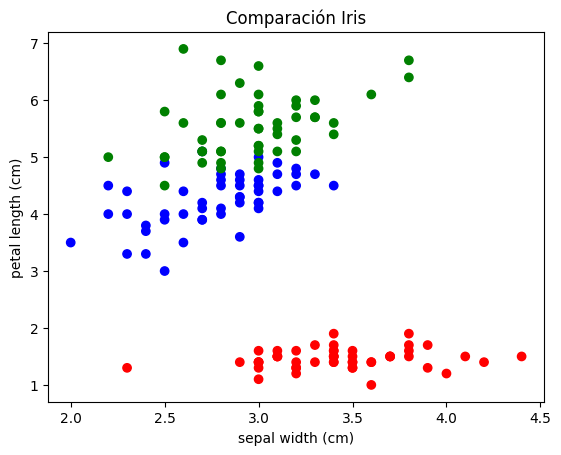

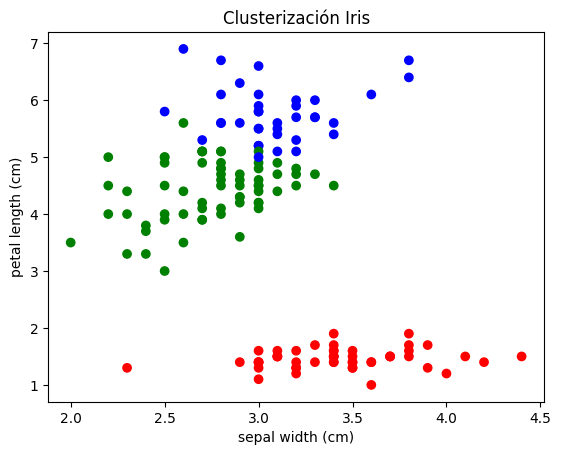

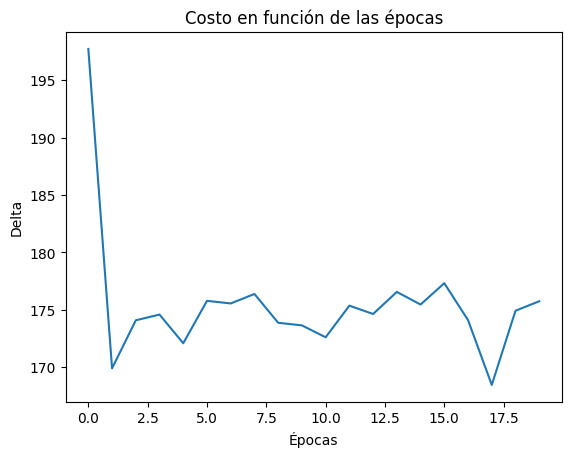

In [ ]:
# El dataset tiene 4 descriptores o características (entradas) y 3 clases (salidas).
dataset = datasets.load_iris()
features = np.array(dataset.data[:,:4])
label = np.array(dataset.target)
label = np.resize(label, (label.shape[0],1))
final_data = np.hstack((features, label))

## Ejemplo usando el segundo y tercer descriptor.
colors={0:'red', 1:'blue', 2:'green'} # Código de colores para las clases

# Gráfica original para comparación
data_pd = pd.DataFrame(final_data, columns=["a", "b", "c", "d", "l"])
plt.scatter(features[:,1], features[:,2], c=data_pd.iloc[:,4].apply(lambda x: colors[x]))
plt.xlabel(dataset.feature_names[1])
plt.ylabel(dataset.feature_names[2])
plt.title("Comparación Iris")
plt.savefig('Iris_original.png')   # Ejemplo para guardar gráfica. Así la tiene en mejor calidad.
plt.show()

# Clusterización y gráfica
clustered_data, delta = neuro_clustering(np.array(data_pd.iloc[:,:4]), 3)       # Acá se evalúan los clusters resultantes. k=3 en este caso.
plt.scatter(clustered_data.iloc[:,1], clustered_data.iloc[:,2], c=clustered_data.iloc[:,4].apply(lambda x: colors[x]))
plt.xlabel(dataset.feature_names[1])
plt.ylabel(dataset.feature_names[2])
plt.title("Clusterización Iris")
plt.savefig('Iris_clustered.png')
plt.show()

# Gráfica del costo
plt.plot(delta)
plt.xlabel("Épocas")
plt.ylabel("Delta")
plt.title("Costo en función de las épocas")
plt.savefig('Iris_delta.png')
plt.show()